## 根據RGB動態調整SpecialConV

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import cv2
import numpy as np
import os
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# 檢查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義動態卷積模塊
class SpecialConv2d(nn.Module):
    def __init__(self, out_channels, kernel_size, stride=1, padding=0):
        super(SpecialConv2d, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        batch_size, in_channels, height, width = x.size()
        
        # 動態生成卷積核權重
        weight = torch.randn(self.out_channels, in_channels, self.kernel_size, self.kernel_size).to(x.device)
        
        # 進行卷積操作
        output = F.conv2d(x, weight, stride=self.stride, padding=self.padding)
        return output
    
# 定義RRDB模塊
class RRDB(nn.Module):
    def __init__(self, in_channels, growth_channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(growth_channels, growth_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(growth_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out + residual

# 定義CustomCNN_SpecialConv模型
class CustomCNN_SpecialConv(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN_SpecialConv, self).__init__()
        self.conv1 = SpecialConv2d(64, kernel_size=3, padding=1)
        self.rrdb1 = RRDB(64, 32)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 32 * 32, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.rrdb1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

# 定義數據集類
class ImageDataset(Dataset):
    def __init__(self, file_path, transform=None, channels="RGB"):
        with open(file_path, 'r') as f:
            lines = f.readlines()
        self.img_labels = [line.strip().split() for line in lines]
        self.transform = transform
        self.channels = channels
        self.labels = [int(label) for _, label in self.img_labels]
        self.classes = list(set(self.labels))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = int(label)

        # 根據指定的通道選擇相應的數據
        if self.channels == "R":
            image = image[:, :, 0:1]
        elif self.channels == "G":
            image = image[:, :, 1:2]
        elif self.channels == "B":
            image = image[:, :, 2:3]
        elif self.channels == "RG":
            image = image[:, :, 0:2]
        elif self.channels == "GB":
            image = image[:, :, 1:3]
        elif self.channels == "RGB":
            image = image[:, :, 0:3]

        if self.transform:
            image = self.transform(image)

        return image, label

# 根據channels動態設置數據轉換，包含數據增強
def get_transform(channels):
    if channels == "R" or channels == "G" or channels == "B":
        mean = [0.485]
        std = [0.229]
    elif channels == "RG" or channels == "GB":
        mean = [0.485, 0.456]
        std = [0.229, 0.224]
    else:  # RGB
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
    return transform

# 保存模型狀態的函數，包含損失歷史
def save_checkpoint(epoch, model, optimizer, loss_history, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history,
    }, path)

# 修改加載模型狀態的函數，將模型和優化器作為參數傳入
def load_checkpoint(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    return start_epoch, loss_history

# 訓練和評估模型的函數
def train_and_evaluate(channels="RGB"):
    # 創建數據轉換
    transform = get_transform(channels)

    # 創建數據集和數據加載器
    train_dataset = ImageDataset(file_path='train.txt', transform=transform, channels=channels)
    val_dataset = ImageDataset(file_path='val.txt', transform=transform, channels=channels)
    test_dataset = ImageDataset(file_path='test.txt', transform=transform, channels=channels)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 創建模型和其他訓練參數
    model = CustomCNN_SpecialConv(num_classes=len(train_dataset.classes)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    checkpoint_path = f"checkpoint_cnn_{channels}.pth"

    # 檢查是否有保存的狀態，並加載
    if os.path.exists(checkpoint_path):
        start_epoch, loss_history = load_checkpoint(checkpoint_path, model, optimizer)
        print(f"Resuming training from epoch {start_epoch}")
    else:
        start_epoch = 0
        loss_history = []

    # 訓練模型的函數
    def train_model(num_epochs):
        nonlocal loss_history
        for epoch in range(start_epoch, num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            scheduler.step()
            epoch_loss = running_loss / len(train_loader)
            loss_history.append(epoch_loss)
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

            # 保存模型狀態
            save_checkpoint(epoch + 1, model, optimizer, loss_history, checkpoint_path)

            # 驗證階段
            model.eval()
            total = 0
            correct = 0
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += criterion(outputs, labels).item()

            val_loss = val_loss / len(val_loader)
            print(f'Validation Accuracy: {100 * correct / total}%, Validation Loss: {val_loss}')

        # 繪製損失值
        plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
        plt.title('Training Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    # 評估模型的函數
    def evaluate_model(loader):
        model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')

        print(classification_report(all_labels, all_preds, target_names=[str(cls) for cls in train_dataset.classes]))

    # 訓練模型
    train_model(10)
    
    print("========================================")

    # 推論模型
    evaluate_model(test_loader)


Resuming training from epoch 10


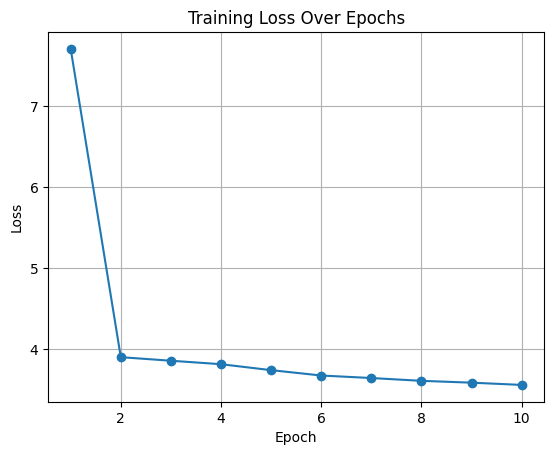

Accuracy: 0.0822
Precision: 0.0779
Recall: 0.0822
F1 Score: 0.0696
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.50      0.22      0.31         9
           2       0.16      0.33      0.21         9
           3       0.33      0.11      0.17         9
           4       0.25      0.22      0.24         9
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         9
          13       0.33      0.11      0.17         9
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         9
          16  

/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [19]:
# 訓練和測試使用不同通道數據的模型
train_and_evaluate(channels="RGB")

Resuming training from epoch 10


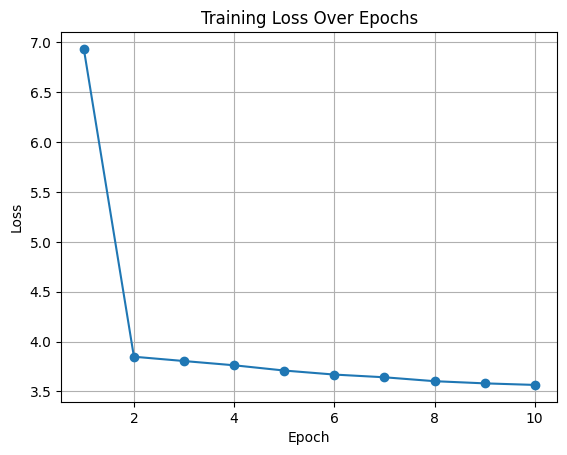

Accuracy: 0.0289
Precision: 0.0325
Recall: 0.0289
F1 Score: 0.0152
              precision    recall  f1-score   support

           0       0.02      0.22      0.03         9
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         9
           3       0.05      0.22      0.08         9
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         9
          16  

/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [20]:
train_and_evaluate(channels="RG")

Resuming training from epoch 10


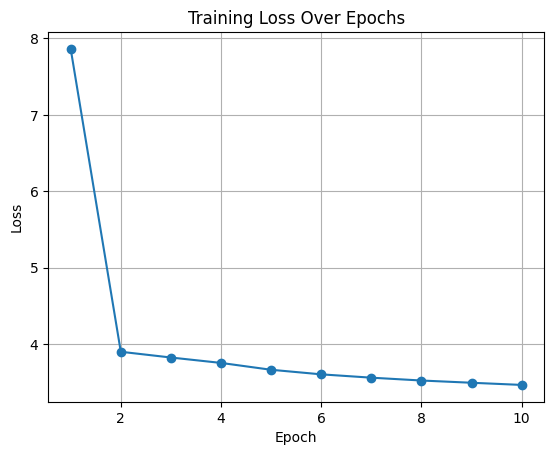

Accuracy: 0.1178
Precision: 0.1205
Recall: 0.1178
F1 Score: 0.1050
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.06      0.11      0.08         9
           2       0.00      0.00      0.00         9
           3       0.25      0.44      0.32         9
           4       0.33      0.22      0.27         9
           5       0.22      0.22      0.22         9
           6       0.00      0.00      0.00         9
           7       0.12      0.11      0.12         9
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         9
          10       0.50      0.11      0.18         9
          11       0.00      0.00      0.00         9
          12       1.00      0.22      0.36         9
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         9
          15       0.20      0.22      0.21         9
          16  

/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [21]:
train_and_evaluate(channels="R")